## API lab

### Introduction:

While many data sets are provided though downloadable files, some are provided through application programming interface (API) which allows the code to access some data without downloading the entire dataset.

APIs provide sets of functions and procedures that allow accessing the features or data from an application or other service.


#### REST API
REST is essentially a set of useful conventions for structuring a web API. 'Web API' means an API that you interact with over HTTP, making requests to specific URLs, and often getting relevant data back in the response.

### Uses
- Scraping real time information - useful for example for accessing travel route info from mapping applications, social media feed. And any other data that being updated in real time or is changing quickly. Another example of this is stock price data. It doesn’t really make sense to regenerate a data set and download it every minute 
- Getting only the desired tables through filtering instead of downloading the entire data sets. Reddit comments are one example. It doesn’t make much sense (plus won't be permitted) to download the entire Reddit database if we want only some information

### General Terminology

#### Types of requests
characterize what action we are going to take by referring to the API

- GET: retrieve information (like search results). This is the most common type of request. Using it, we can get the data we are interested in from those that the API is ready to share.
- POST: adds new data to the server. Using this type of request, you can, for example, add a new item to your inventory.
- PUT: changes existing information. For example, using this type of request, it would be possible to change the color or value of an existing product.
- DELETE: deletes existing information

#### Status codes
briefly describe the result of the call.

- 200 – OK. The request was successful. The answer itself depends on the method used (GET, POST, etc.) and the API specification.
- 204 – No Content. The server successfully processed the request and did not return any content.
- 301 – Moved Permanently. The server responds that the requested page (endpoint) has been moved to another address and redirects to this address.
- 400 – Bad Request. The server cannot process the request because the client-side errors (incorrect request format).
- 401 – Unauthorized. Occurs when authentication was failed, due to incorrect credentials or even their absence.
- 403 – Forbidden. Access to the specified resource is denied.
- 404 – Not Found. The requested resource was not found on the server.
- 500 – Internal Server Error. Occurs when an unknown error has occurred on the server.

#### Endpoints
Usually, an Endpoint is a specific address (for example, https://weather-in-london.com/forecast), by referring to which you get access to certain features/data (in this example above – the weather forecast for London). Commonly, the name (address) of the endpoint corresponds to the functionality it provides.

### HereMap API
Provides mapping, location data and routing information services worldwide. Routing info is available for transit, walking, driving, bike modes.


In [1]:
import pandas as pd
import glob #Unix style pathname pattern expansion
import numpy as np
from dateutil import parser #powerful extensions to datetime; offers a generic date/time string parser
import time
from tqdm import tqdm #Customisable progressbar for iterators
try: #spelling depends on enviroment version 
    import urllib2 as urllib #URL handling module
except ImportError:
    import urllib.request as urllib
import json
import geopandas as gpd
import sys
from IPython.display import clear_output #Clears the output of the current cell receiving output
import requests #the module for making HTTP requests in Python; provides GET funcionality

#### Request API key by creating free account 
https://developer.here.com/sign-up?create=Freemium-Basic&keepState=true&step=account

#### Example 1: getting driving time

#### API endpoint
https://developer.here.com/documentation/routing-api/8.3.1/dev_guide/topics/send-request.html

#### Sample request

An API request needs an endpoint link with API key to fetch data. In some cases, you may also need appID and appCode to make a request. When you make a account in a particular API service, you will be asked to create and name your app. When you finish this step, you will be provided with a unique API key together with appID and appCode as a unique identifier for your app.

Please not that various APIs have certain restrictions on their usage. Please make sure to read the the usage terms before making acccount (especially if you are asked to enter your payment info beforehand!)

HereMap API has 250k free requests per month. (And it does not ask for credit card info when you create an account)

Also, please note the below example uses an API key for this lab's demonstration purposes only. Please create your HereMap account and get your unique API key when attempting the lab or homeworks yourself.

retreive a driving route between the two given points

In [2]:
# enter your api key from HereMap
apiKey = 'PeGRmBEmT4i0EL5OqB4VhZDyRhLyqqW8U0dO-QtfOaU'

lon_pickup, lat_pickup = -73.972136, 40.744301 ##origin: A point in Manhattan (around E 35th street)
lon_dropoff, lat_dropoff = -74.172945, 40.680108 # destination: Newark airport

Note the driving API endpoint is 'https://route.ls.hereapi.com/routing/7.2/calculateroute.json?apiKey={}&waypoint0=geo!{},{}&waypoint1=geo!{},{}&mode=fastest;car;traffic:disabled', which essentially gives the driving directions from origin to destination together with a summary of the whole trip.

For the above origin-destination lat-longs, the endpoint will look like

'https://route.ls.hereapi.com/routing/7.2/calculateroute.json?apiKey=W6GB9G-e0QHV5Nes77OLAX5FxecH7IHEIuObpc6WJnU&waypoint0=geo!40.744301,-73.972136&waypoint1=geo!40.680108,-74.172945&mode=fastest;car;traffic:disabled'

Basically, the origin lat-long go in after the 'waypoint0=geo!' field and destination lat-long go in after 'waypoint1=geo!' field. Instead of manually putting these lat-long in the code, the pythonic way to do this is by the 'format' function. Wherever we need to insert variables, we put '{}' in the url and then specify the variables in their respective order of appearing in the url in the 'format' command.



In [3]:
url = str('https://route.ls.hereapi.com/routing/7.2/calculateroute.json?apiKey={}&waypoint0=geo!{},{}&waypoint1=geo!{},{}&mode=fastest;car;traffic:disabled'.format(
    apiKey, lat_pickup, lon_pickup, lat_dropoff, lon_dropoff))

print(url)

https://route.ls.hereapi.com/routing/7.2/calculateroute.json?apiKey=PeGRmBEmT4i0EL5OqB4VhZDyRhLyqqW8U0dO-QtfOaU&waypoint0=geo!40.744301,-73.972136&waypoint1=geo!40.680108,-74.172945&mode=fastest;car;traffic:disabled


Now we'll make a request with the below command

In [4]:
data = urllib.urlopen(url).read().decode('utf-8')
data = json.loads(data)

The fetched data gives driving directions together with a summary of the whole trip

In [5]:
data

{'response': {'metaInfo': {'timestamp': '2021-12-26T12:04:29Z',
   'mapVersion': '8.30.127.154',
   'moduleVersion': '7.2.202151-9829',
   'interfaceVersion': '2.6.77',
   'availableMapVersion': ['8.30.127.154']},
  'route': [{'waypoint': [{'linkId': '+973152345',
      'mappedPosition': {'latitude': 40.7441169, 'longitude': -73.9722743},
      'originalPosition': {'latitude': 40.744301, 'longitude': -73.9721361},
      'type': 'stopOver',
      'spot': 0.0864198,
      'sideOfStreet': 'right',
      'mappedRoadName': 'E 35th St',
      'label': 'E 35th St',
      'shapeIndex': 0,
      'source': 'user'},
     {'linkId': '-1288125068',
      'mappedPosition': {'latitude': 40.6790655, 'longitude': -74.1703952},
      'originalPosition': {'latitude': 40.6801079, 'longitude': -74.172945},
      'type': 'stopOver',
      'spot': 0.1372378,
      'sideOfStreet': 'neither',
      'mappedRoadName': 'New Jersey Tpke S',
      'label': 'New Jersey Tpke S - I-95',
      'shapeIndex': 237,
      

The retrived output contains all information in the 'response' key. In the 'response', there is information about intermediate directions (which street to take a turn, etc.) in the 'route' key. Also present in the 'route' key is the summary of the trip (time, distance, road types etc.)

Let's print the time and distance of the whole trip

In [6]:
# get travel time in seconds
data['response']['route'][0]['summary']['travelTime']

1700

In [7]:
# travel distance in meters
data['response']['route'][0]['summary']['distance']

25921

#### Example 2: getting transit time

#### API endpoint
https://developer.here.com/documentation/public-transit/dev_guide/index.html

In [8]:
apiKey = 'PeGRmBEmT4i0EL5OqB4VhZDyRhLyqqW8U0dO-QtfOaU'
lon_pickup, lat_pickup = -73.972136, 40.744301
lon_dropoff, lat_dropoff = -74.008704, 40.708592

url = str('https://transit.router.hereapi.com/v8/routes?apiKey={}&origin={},{}&destination={},{}').format(apiKey, lat_pickup, lon_pickup, 
                                                                                                        lat_dropoff, lon_dropoff)
# url = str('https://transit.ls.hereapi.com/v8/route.json?apiKey={}&routing=all&dep={},{}&arr={},{}&time=2021-09-21T07%3A30%3A00'.format(apiKey, lat_pickup, lon_pickup, 
#                                                                                                         lat_dropoff, lon_dropoff))

data = urllib.urlopen(url).read().decode('utf-8')
data = json.loads(data)
data

{'routes': [{'id': 'R003d20-C0',
   'sections': [{'id': 'R003d20-C0-S0',
     'type': 'pedestrian',
     'departure': {'time': '2021-12-26T07:06:00-05:00',
      'place': {'type': 'place',
       'location': {'lat': 40.744301, 'lng': -73.972136}}},
     'arrival': {'time': '2021-12-26T07:14:00-05:00',
      'place': {'name': '2 AV/E 33 St',
       'type': 'station',
       'location': {'lat': 40.743851, 'lng': -73.976632},
       'id': '717060703'}},
     'transport': {'mode': 'pedestrian'}},
    {'id': 'R003d20-C0-S1',
     'type': 'transit',
     'departure': {'time': '2021-12-26T07:14:00-05:00',
      'place': {'name': '2 AV/E 33 St',
       'type': 'station',
       'location': {'lat': 40.743851, 'lng': -73.976632},
       'id': '717060703'},
      'delay': -240},
     'arrival': {'time': '2021-12-26T07:35:00-05:00',
      'place': {'name': 'Water St/John St',
       'type': 'station',
       'location': {'lat': 40.706813, 'lng': -74.00523},
       'id': '717061309'},
      'delay'

Note that retrieved output keys are different from what we obtained in case of driving direction request. 

Here all data is present in the 'routes' key with information regarding intermediate stations. There are multiple transit sections with each segment, representing either a pedestrian or a transit segment, containing departure and arrival times, duration, and coordinates. To get the overall duration of the trip, we just need departure time from first segment and arrival time at last segment.

Important: You may get the retrieved repsonse other than above if any transit route is not available from specified origin to destination. 
Invalid responses are 'Timestamp out of validity period' and 'No result found'

total travel time: subtract last segment arrival time and first segment departure time to get total time

'parser.parse is a tool to convert str into timestamps

In [9]:
x = parser.parse(data['routes'][0]['sections'][-1]['departure']['time']) - parser.parse(data['routes'][0]['sections'][0]['departure']['time'])
x.seconds

1740

Converting to minutes

In [10]:
x.seconds/60

29.0

## Now access information for a sample of selected origin-destination points

In [13]:
# sample points lat-longs

df = pd.read_csv('Data/samplePoints.csv')
df.head()

,LocationID,lon_pickup,lat_pickup,LocationID2,lon_dropoff,lat_dropoff
0,1,-74.174000,40.691831,145,-73.948891,40.745379
1,2,-73.831299,40.616745,203,-73.739473,40.657853
2,3,-73.847422,40.864474,77,-73.895364,40.666559
3,4,-73.976968,40.723752,158,-74.008984,40.735035
4,5,-74.188484,40.552659,123,-73.964334,40.599954


In [14]:
len(df) ##one random point per each zip code

263

Function for getting driving time for a dataframe of above type

In [15]:
def driving(file, apiKey): 
    '''
    Input: the file that contain origin-destination lan/long information; keys from Map
    Output: list of driving times corresponding the input O-D pairs
    '''
    duration_list= []  # list for storing times
    for index, row in tqdm(file.iterrows()): # iterating through all rows of sample points
        lon_pickup = row['lon_pickup']  
        lat_pickup = row['lat_pickup']
        lon_dropoff = row['lon_dropoff']
        lat_dropoff = row['lat_dropoff']
        
        # specifying origin-desination lat-longs in the endpoint and making request
        url = str('https://route.ls.hereapi.com/routing/7.2/calculateroute.json?apiKey={}&waypoint0=geo!{},{}&waypoint1=geo!{},{}&mode=fastest;car;traffic:disabled'.format(apiKey, lat_pickup, lon_pickup, lat_dropoff, lon_dropoff))
        data = urllib.urlopen(url).read().decode('utf-8')
        data = json.loads(data)
        
        # append travel time to 'duration' list, nan if no travel time retrieved
        try:    
            duration = data['response']['route'][0]['summary']['travelTime']
        except:
            duration = np.nan
            
        duration_list.append(duration)

    return duration_list  

Passing 10 random O-D pairs

In [16]:
sample = df.sample(10, random_state=2020)
sample.reset_index(drop=True, inplace=True)

sample

,LocationID,lon_pickup,lat_pickup,LocationID2,lon_dropoff,lat_dropoff
0,110,-74.128342,40.545780,254,-73.858948,40.882157
1,51,-73.828264,40.873973,92,-73.828859,40.761102
2,166,-73.961764,40.809457,234,-73.990458,40.740337
3,207,-73.899353,40.763986,248,-73.872289,40.834165
4,195,-74.009178,40.675549,68,-73.999917,40.748428
5,251,-74.125348,40.616880,114,-73.997380,40.728340
6,71,-73.937966,40.644288,118,-74.132979,40.586555
7,139,-73.744234,40.677098,202,-73.949952,40.761900
8,76,-73.876821,40.660935,240,-73.881978,40.894599
9,165,-73.956825,40.620924,258,-73.855767,40.688721


Calling the function to get responses from API

In [17]:
sample['driving_time'] = driving(sample, apiKey)
sample

10it [00:01,  6.11it/s]


,LocationID,lon_pickup,lat_pickup,LocationID2,lon_dropoff,lat_dropoff,driving_time
0,110,-74.128342,40.545780,254,-73.858948,40.882157,4302
1,51,-73.828264,40.873973,92,-73.828859,40.761102,1312
2,166,-73.961764,40.809457,234,-73.990458,40.740337,1183
3,207,-73.899353,40.763986,248,-73.872289,40.834165,1213
4,195,-74.009178,40.675549,68,-73.999917,40.748428,1091
5,251,-74.125348,40.616880,114,-73.997380,40.728340,1990
6,71,-73.937966,40.644288,118,-74.132979,40.586555,2251
7,139,-73.744234,40.677098,202,-73.949952,40.761900,2318
8,76,-73.876821,40.660935,240,-73.881978,40.894599,2626
9,165,-73.956825,40.620924,258,-73.855767,40.688721,1943


### NYC Open data API: 
NYC open data offers API for almost every available data from crime, housing, 311, taxi etc.
Also its free for the most part and no account needed

https://opendata.cityofnewyork.us/

#### Example: Endpoint for 2018 taxi data
https://data.cityofnewyork.us/resource/t29m-gskq.json

In [18]:
# some parameters to filter the data. We can specify as many parameters as columns in the table.
# reference: https://dev.socrata.com/foundry/data.cityofnewyork.us/t29m-gskq

# extracting info for a specific O-D pair corresponding to near E 35th st as pick up and Newark airport as drop off
# this is around the same pick-up and drop-off location we used to get driving time from HereMap API
parameter = {'pulocationid':162, 'dolocationid':1}



making API request

'requests' is another package of making web requests. Highly uselful in the case of REST APIs and we can provide parameters together in one line of code. We'll use the 'get' method to retrieve data

In [19]:
url =  "https://data.cityofnewyork.us/resource/t29m-gskq.json"
r = requests.get(url = url, params=parameter)
data = r.json()

fisrt three returned observations

In [20]:
data[:3]

[{'vendorid': '1',
  'tpep_pickup_datetime': '2018-02-14T13:10:19.000',
  'tpep_dropoff_datetime': '2018-02-14T13:53:15.000',
  'passenger_count': '1',
  'trip_distance': '17.40',
  'ratecodeid': '3',
  'store_and_fwd_flag': 'N',
  'pulocationid': '162',
  'dolocationid': '1',
  'payment_type': '1',
  'fare_amount': '68.5',
  'extra': '0',
  'mta_tax': '0',
  'tip_amount': '12',
  'tolls_amount': '10.5',
  'improvement_surcharge': '0.3',
  'total_amount': '91.3'},
 {'vendorid': '2',
  'tpep_pickup_datetime': '2018-02-14T14:25:43.000',
  'tpep_dropoff_datetime': '2018-02-14T15:05:18.000',
  'passenger_count': '2',
  'trip_distance': '17.40',
  'ratecodeid': '3',
  'store_and_fwd_flag': 'N',
  'pulocationid': '162',
  'dolocationid': '1',
  'payment_type': '1',
  'fare_amount': '68',
  'extra': '0',
  'mta_tax': '0',
  'tip_amount': '0',
  'tolls_amount': '16.1',
  'improvement_surcharge': '0.3',
  'total_amount': '84.4'},
 {'vendorid': '1',
  'tpep_pickup_datetime': '2018-02-14T14:38:48

Note that the returned request contains information reagrding pick up and drop off times, distance covered, fare amount, number of passengers etc. Essentially, it returns all info provided by TLC in any csv file.

Let's get travel time from first observation

In [21]:
# travel time in seconds
parser.parse(data[0]['tpep_dropoff_datetime']) - parser.parse(data[0]['tpep_pickup_datetime'])

datetime.timedelta(seconds=2576)

Note the travel time returned is around 40 minutes compared to around 28 minutes from driving time retrieved from HereMap API before. Also note time can vary based on the pick up times, the above time of 40 min correspond to pick up around 7pm.



#### get yellow taxi times for O-D pairs as before

#### Note: taxi data can be full of absurd values in terms of travel times/fares/distances. So we need to filter out all noise while we extract. 
#### We'll make the same checks for filtering as we did in the taxi data lab

1. Get rid of observations with travel time > 1 min and < 100 min
2. Speed (distance/time) should be > 2mph and <80mph
3. Fare should be < 300 USD and > 2.5 USD
4. distance traveled < 100 and > 0.3

In [22]:
def taxiTime(df):
    
    times = [] # list for storing travel times
    
    for index, row in df.iterrows(): # iterating through all rows of sample points
        
        # specify parameters for making request
        parameters = {'pulocationid':int(row['LocationID']), 'dolocationid':int(row['LocationID2'])}
        
        url =  "https://data.cityofnewyork.us/resource/t29m-gskq.json"
        r = requests.get(url = url, params=parameters)
        data = r.json()
        
        travelTime = []
        
        for obs in data: # iterating through each returned observation for the returned data 
            
            # making sanity checks and appending times to 'traveTime' list
            try:
                time = parser.parse(obs['tpep_dropoff_datetime']) - parser.parse(obs['tpep_pickup_datetime'])
                time = time.total_seconds()
                fare = float(obs['fare_amount'])
                distance = float(obs['trip_distance'])
                speed = distance/(time/3600)

                if (time < 6000 and time > 60 and fare < 200  
                    and fare > 2.5 and fare < 300 and speed < 80  and speed > 2 and distance > 0.3 and 
                    distance < 100):
                    travelTime.append(time)
                    
            except: 
                pass
            
        # now appending the mean of travel times retrieved above to the 'times' list
    
        times.append(np.mean(travelTime))
        
        
    return times

In [23]:
sample['TLC_avgtime'] = taxiTime(sample)
sample

C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,LocationID,lon_pickup,lat_pickup,LocationID2,lon_dropoff,lat_dropoff,driving_time,TLC_avgtime
0,110,-74.128342,40.545780,254,-73.858948,40.882157,4302,NaN
1,51,-73.828264,40.873973,92,-73.828859,40.761102,1312,1398.000000
2,166,-73.961764,40.809457,234,-73.990458,40.740337,1183,1834.531062
3,207,-73.899353,40.763986,248,-73.872289,40.834165,1213,NaN
4,195,-74.009178,40.675549,68,-73.999917,40.748428,1091,2149.000000
5,251,-74.125348,40.616880,114,-73.997380,40.728340,1990,NaN
6,71,-73.937966,40.644288,118,-74.132979,40.586555,2251,3126.000000
7,139,-73.744234,40.677098,202,-73.949952,40.761900,2318,NaN
8,76,-73.876821,40.660935,240,-73.881978,40.894599,2626,3203.666667
9,165,-73.956825,40.620924,258,-73.855767,40.688721,1943,2622.000000


### Homework

1. Extract 2018/2019 FHV and shared FHV data and compare with taxi times from TLC and driving times from HereMap API for 50 random O-D pairs.
2. Extra credit: Using geocoding API from HereMAPs

### Retrieving FHV and shared FHV data

#### FHV (for hire vehicles) refers to cars belonging to privately owned companies and entities like Uber, Lyft etc. Shared for hire vehicles (SFHV) trips are where two or more people share the same trip (UberPool etc.)


use API endpoint: https://data.cityofnewyork.us/resource/u6nh-b56h.json

for shared FHV, use parameter 'SR_flag': 1 and 0 for non shared FHV

### Task 1: get sample request for a single O-D pair for both FHV and shared FHV

In [27]:
# write parameters here for FHV
parameter = {'pulocationid':162, 'dolocationid':1, 'sr_flag':1}


In [28]:
# code here, get travel time from one observation for above O-D pair

In [29]:
url = "https://data.cityofnewyork.us/resource/u6nh-b56h.json"
r = requests.get(url = url, params=parameter)
data = r.json()
data[0]

{'dispatching_base_num': 'B02835',
 'pickup_datetime': '2019-01-01T01:51:19.000',
 'dropoff_datetime': '2019-01-01T02:37:34.000',
 'pulocationid': '162',
 'dolocationid': '1',
 'sr_flag': '1'}

In [30]:
# write parameters here for non shared FHV
parameter_n = {'pulocationid':162, 'dolocationid':1, 'sr_flag':None}
#get shared FHV travel time from one observation for above O-D pair
parser.parse(data[0]['dropoff_datetime']) - parser.parse(data[0]['pickup_datetime'])


datetime.timedelta(seconds=2775)

### Task 2. Write the function for getting FHV and Shared FHV times for 50 sample O-D pairs. 

#### Hint: see above that the returned FHV/shared FHV data has column names 'pickup_datetime' and 'dropoff_datetime' instead of 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' used in the functions above. So make sure to change these names when writing the code below


Also make necessary filtering to remove outliers. Remember, in this data, just travel times are available, so we don't need any other variable outlier filtering.

In [33]:
# sample points

df = pd.read_csv('Data/samplePoints.csv')
sample = df.sample(50, random_state=2020)
sample.head()

,LocationID,lon_pickup,lat_pickup,LocationID2,lon_dropoff,lat_dropoff
109,110,-74.128342,40.545780,254,-73.858948,40.882157
50,51,-73.828264,40.873973,92,-73.828859,40.761102
165,166,-73.961764,40.809457,234,-73.990458,40.740337
206,207,-73.899353,40.763986,248,-73.872289,40.834165
194,195,-74.009178,40.675549,68,-73.999917,40.748428


In [34]:
# write function for getting average FHV and SFHV times
#### hint: function will essentially be the same as for FHV except for the change in the request parameters and returning 
def FHVtimes(df):
    
    times = [] # list for storing travel times

    for index, row in df.iterrows(): # iterating through all rows of sample points
        
        # specify parameters for making request
        parameters = {'pulocationid':int(row['LocationID']), 'dolocationid':int(row['LocationID2']), 'sr_flag': None}
        
        url =  "https://data.cityofnewyork.us/resource/u6nh-b56h.json"
        r = requests.get(url = url, params= parameters)
        data = r.json()
        
        travelTime = []
        
        for obs in data: # iterating through each returned observation for the returned data 
            
            # making sanity checks and appending times to 'traveTime' list
            try:
                time = parser.parse(obs['dropoff_datetime']) - parser.parse(obs['pickup_datetime'])
                time = time.total_seconds()
                if (time < 6000 and time > 60):
                    travelTime.append(time)
                    
            except: 
                pass
            
        # now appending the mean of travel times retrieved above to the 'times' list
        times.append(np.mean(travelTime))
    
    return times

In [35]:
def SFHVtimes(df):
    
    times = [] # list for storing travel times

    for index, row in df.iterrows(): # iterating through all rows of sample points
        
        # specify parameters for making request
        parameters = {'pulocationid':int(row['LocationID']), 'dolocationid':int(row['LocationID2']), 'sr_flag': 1}
        
        url =  "https://data.cityofnewyork.us/resource/u6nh-b56h.json"
        r = requests.get(url = url, params=parameters)
        data = r.json()
        
        travelTime = []
        
        for obs in data: # iterating through each returned observation for the returned data 
            
            # making sanity checks and appending times to 'traveTime' list
            try:
                time = parser.parse(obs['dropoff_datetime']) - parser.parse(obs['pickup_datetime'])
                time = time.total_seconds()
                if (time < 6000 and time > 60):
                    travelTime.append(time)
                    
            except: 
                pass
            
        # now appending the mean of travel times retrieved above to the 'times' list
    
        times.append(np.mean(travelTime))
    
    return times

In [36]:
# create new columns in the above 'sample' dataframe named 'FHV time' and 'SFHV time' with above retrieved times
sample['FHV time'] = FHVtimes(sample)
sample['SFHV time'] = SFHVtimes(sample)
sample

C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,LocationID,lon_pickup,lat_pickup,LocationID2,lon_dropoff,lat_dropoff,FHV time,SFHV time
109,110,-74.128342,40.545780,254,-73.858948,40.882157,NaN,NaN
50,51,-73.828264,40.873973,92,-73.828859,40.761102,1431.289157,1493.700000
165,166,-73.961764,40.809457,234,-73.990458,40.740337,1890.944193,2217.561224
206,207,-73.899353,40.763986,248,-73.872289,40.834165,1511.000000,NaN
194,195,-74.009178,40.675549,68,-73.999917,40.748428,1640.843750,1828.200000
250,251,-74.125348,40.616880,114,-73.997380,40.728340,2540.142857,NaN
70,71,-73.937966,40.644288,118,-74.132979,40.586555,2023.000000,NaN
138,139,-73.744234,40.677098,202,-73.949952,40.761900,NaN,NaN
75,76,-73.876821,40.660935,240,-73.881978,40.894599,2593.000000,NaN
164,165,-73.956825,40.620924,258,-73.855767,40.688721,2505.500000,2552.625000


### Task 3: Comparison of times for FHV and shared FHV

In [37]:
## check number of 'Nan' values (if any) retrieved from travel times
FHV_nan_count = sample['FHV time'].isna().sum()
SFHV_nan_count = sample['SFHV time'].isna().sum()
print(FHV_nan_count, SFHV_nan_count)

8 20


In [38]:
# remove the rows if any of the retrieved FHV or shared FHV times has 'Nan'
sample.dropna(inplace=True)
sample.shape

(30, 8)

In [39]:
# make scatter plot comparing FHV times with shared FHV times for the 50 sample O-D pairs
# add a FHV=SFHV baseline to see if most of the points are above (FHV time>SFHV time) or below (FHV time<SFHV time)

# hint: use plt.plot(var1, var2, 'o') for scatter plots between two variables var1 and var2 of interest

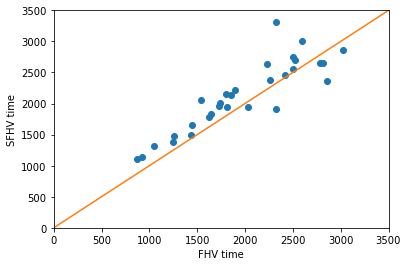

In [40]:
import matplotlib.pyplot as plt
xAxis = sample['FHV time']
yAxis = sample['SFHV time']
plt.xlabel('FHV time')
plt.ylabel('SFHV time')
plt.xlim((0, 3500))
plt.ylim((0, 3500))
plt.plot(xAxis, yAxis, 'o')
plt.plot([0,3500], [0,3500])
plt.show()

we'll use HereAPI again for geocoding. Same API key as before will work. The endpoint for geocoding API is https://geocode.search.hereapi.com/v1/geocode 
Many other companies also provide geocoding API services (eg. Google)

To specify an address, we use the 'q' parameter in the endpoint. For example, if we want to get lat-long for '5 Rue Daunou, 75000 Paris, France', we'll use the following endpoint:

https://geocode.search.hereapi.com/v1/geocode?q=5+Rue+Daunou%2C+75000+Paris%2C+France&apiKey={}

Essentially, we write the addresses as a query with spaces being replaced by '+' and commas being repalced by '%2C'

## Extra credit task- Using one other API : geocoding
Geocoding referes to converting textual addresses into lat-long. Useful in getting a precise location of a place

In [41]:
## try out a geocode request for a random address. Remember to be precise in specifying the address to remove any ambiguity

# API key
key ='PeGRmBEmT4i0EL5OqB4VhZDyRhLyqqW8U0dO-QtfOaU'
# API endpoint with query as your address
url = "https://geocode.search.hereapi.com/v1/geocode?q=5+Rue+Daunou%2C+75000+Paris%2C+France&apiKey={}".format(key)


data = urllib.urlopen(url).read().decode('utf-8')
data = json.loads(data)
data

{'items': [{'title': '5 Rue Daunou, 75002 Paris, France',
   'id': 'here:af:streetsection:bI4Le6cyA.1mlQyLunYpjC:CggIBCCi-9SPARABGgE1',
   'resultType': 'houseNumber',
   'houseNumberType': 'PA',
   'address': {'label': '5 Rue Daunou, 75002 Paris, France',
    'countryCode': 'FRA',
    'countryName': 'France',
    'stateCode': 'IDF',
    'state': 'Île-de-France',
    'county': 'Paris',
    'city': 'Paris',
    'district': '2e Arrondissement',
    'street': 'Rue Daunou',
    'postalCode': '75002',
    'houseNumber': '5'},
   'position': {'lat': 48.86926, 'lng': 2.3321},
   'access': [{'lat': 48.86931, 'lng': 2.33215}],
   'mapView': {'west': 2.33073,
    'south': 48.86836,
    'east': 2.33347,
    'north': 48.87016},
   'scoring': {'queryScore': 0.97,
    'fieldScore': {'country': 1.0,
     'city': 1.0,
     'streets': [1.0],
     'houseNumber': 1.0,
     'postalCode': 0.82}}}]}

In [42]:
## get latitude and longitude from returned json request
print(data['items'][0]['position'])


{'lat': 48.86926, 'lng': 2.3321}
